# Problem Set 2

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on bCourses). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of surveys conducted in 1998
 * "Wave 2" of surveys conducted in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from bCourses. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|------|------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	|gender of head of household (male=1)|
|hohage	|age of head of household|
|age	|years old|
|folnum	|individual id|
|village|	village id|
|sc97	|schooling in 1997|
|grc97  |grade enrolled in 1997

## Notes on Program, Paper & Dataset

### Program
* Gov't social assistance program in Mexico.
* Founded in 2002 - based on program created in 1997
* Provides cash payments to families in exchange for: regular school attendance, health clinic visits and nutrition support
* Conditional Cash Transfer (CCT)

### Paper

* Area: Rural mexico
* Subject: Poor mothers
* IV: education grants provided by the 'Progresa' program
* DV: enrollment rate of children
* Design: poor children in communities 'randomly' selected are compared to those who reside in 'control' communities
    - Probit models used to estimate probability child is enrolled, controlling for additional characteristics of the child, family, community and taking into account attrition
    - 

### Dataset
* We'll look at the columns more specifically down below


---

## Part 1: Descriptive analysis

In [3]:
### Environment

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline  

# The packages you'll need for regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Read in Data
df = pd.read_csv('progresa_sample.csv')


### 1.1	Summary Statistics

Present summary statistics (mean, median and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

*Note:* For this and subsequent problems, you will need to be careful in how you deal with missing (NULL) values. You should not blindly drop rows and columns where any data field is missing.  For instance, in calculating the average `hohwag`, you should average the `hohwag` values from all households that report a value (even if the household does not have a recorded `age` value, for example). 


First things we'll need to separate the columns by type. For the purposes of further analysis, I see three main types:
* `ID columns`: non-demographic, meta-data columns for identification. Should not be included in analysis themselves, and particularly don't lend themselves well to summary stats
* `categorical/binary columns`: generally 0 or 1. Do not lend themselves to `mean`, `median` or `std.Dev` for obvious reasons. But can run other descriptive stats
* `numeric/metric columns`: these are the one's we'll want to actually look at

In [4]:
# Let's look at a basic column summary
display(df.head(5))

# dtype can rule out some, but can also mislead though since a lot of the categorical cols are binary (0,1)
display(df.dtypes)

# use describe for a rough overview
(df
 .describe()
 .transpose()
 .apply(round, 0)
)



,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


year               int64
sex              float64
indig            float64
dist_sec         float64
sc               float64
grc              float64
fam_n              int64
min_dist         float64
dist_cap         float64
poor              object
progresa          object
hohedu             int64
hohwag           float64
welfare_index    float64
hohsex           float64
hohage           float64
age                int64
village            int64
folnum             int64
grc97              int64
sc97             float64
dtype: object

,count,mean,std,min,25%,50%,75%,max
year,77250.0,98.0,1.0,97.0,97.0,98.0,98.0,98.0
sex,77226.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
indig,76950.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
dist_sec,77250.0,2.0,2.0,0.0,1.0,2.0,4.0,15.0
sc,68797.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
grc,70701.0,4.0,2.0,0.0,2.0,4.0,6.0,14.0
fam_n,77250.0,7.0,2.0,1.0,6.0,7.0,9.0,24.0
min_dist,77250.0,103.0,42.0,9.0,71.0,111.0,138.0,170.0
dist_cap,77250.0,148.0,76.0,9.0,92.0,132.0,184.0,360.0
hohedu,77250.0,3.0,3.0,0.0,0.0,2.0,4.0,20.0


In [5]:
# Other investigations
df['sc'].value_counts()
df['sc97'].value_counts()
df['grc97'].value_counts()
df['hohsex'].value_counts()

df['hohedu'].value_counts()
df['hohage'].value_counts()
df['age'].value_counts()


age
8     7329
7     7327
11    7305
12    7209
10    7169
13    7104
9     7090
14    6839
15    6755
16    6413
6     3666
17    3044
Name: count, dtype: int64

#### Column Categories

**ID**: 
* `year`
* `folnum` - [UID]
* `village`

**Categorical** (binary unless o/w noted):
* `sex`
* `indig`
* `sc`
* `poor` (is textual in raw form)
* `progresa` (is textual in raw form)
* `sc97`
* `hohsex`

**Numeric**:
* `dist_sec` (pure continuous)
* `grc` (categorical but sequential)
* `fam_n` (integer)
* `min_dist` (pure continuous)
* `dist_cap` (pure continuous)
* `hohedu` (integer)
* `hohwag` (pure continuous)
* `welfare_index` (continuous metric)
* `hohage` (integer)
* `age` (integer)
* `grc97` (categorical but sequential)


In [6]:
id_cols = ['year','folnum','village'] # skip
cat_cols = ['sex','indig','sc','poor','progresa','sc97','hohsex'] # do other things
metric_cols = ['dist_sec','grc','fam_n','min_dist','dist_cap','hohedu','hohwag','welfare_index','hohage','age','grc97'] # standard summary stats

# Check we have all the cols - ✅
set(df.columns.to_list()) - set(id_cols + cat_cols + metric_cols)
set(id_cols + cat_cols + metric_cols) - set(df.columns.to_list())

# Let's start with Metric cols

## first look for nulls to be safe
cols_w_nulls = (
    df[metric_cols]
    .isnull()
    .any()
) # all cols that contain any nulls

df[metric_cols][cols_w_nulls[~cols_w_nulls].index.to_list()] # select all cols without nulls - not sure it actually matters here since we want to ignore them

# Define summary funcs
metric_summary_funcs = [np.nanmean, np.nanmedian, np.nanstd]

metric_summaries = (
    df[metric_cols]
    .apply(metric_summary_funcs)
    .transpose()
    .round(2)
    .rename(columns=lambda x: x.replace('nan', ''))
)
display(metric_summaries)

,mean,median,std
dist_sec,2.42,2.28,2.23
grc,3.96,4.00,2.50
fam_n,7.22,7.00,2.35
min_dist,103.45,111.23,42.09
dist_cap,147.67,132.00,76.06
hohedu,2.77,2.00,2.66
hohwag,586.99,500.00,788.13
welfare_index,690.35,685.00,139.49
hohage,44.44,43.00,11.62
age,11.37,11.00,3.17


In [7]:
# Now for the cartegorical ones
df[cat_cols].head()

## We'll need to transform the two text cols
display(df['poor'].value_counts())
### `poor`
poor_dict = {'pobre': 1, 'no pobre': 0}
df['poor'] = [poor_dict[x] for x in df['poor']]

# ### `progresa`
display(df['progresa'].value_counts())
progresa_dict = {'basal': 1, '0': 0} # note: this doesn't really matter?
df['progresa'] = [progresa_dict[x] for x in df['progresa']]

display(df[['poor', 'progresa']].value_counts())

# now for the actual summary funcs - let's just go with mean??

# first check nulls?

df[cat_cols]
cat_summaries = pd.DataFrame({
    'mean': df[cat_cols].apply(np.nanmean),
    'median': np.NaN, # just make this blank cause it doesn't make sense
    'std': df[cat_cols].apply(np.nanstd),
})
cat_summaries

poor
pobre       65392
no pobre    11858
Name: count, dtype: int64

progresa
basal    47560
0        29690
Name: count, dtype: int64

poor  progresa
1     1           40444
      0           24948
0     1            7116
      0            4742
Name: count, dtype: int64

,mean,median,std
sex,0.512211,NaN,0.499851
indig,0.298324,NaN,0.457522
sc,0.819818,NaN,0.384339
poor,0.846498,NaN,0.360470
progresa,0.615663,NaN,0.486438
sc97,0.813922,NaN,0.389169
hohsex,0.925185,NaN,0.263093


In [8]:
# Combine and output 1.1 answer
pd.concat(
    [metric_summaries,
    cat_summaries]
).sort_index()

,mean,median,std
age,11.370000,11.00,3.170000
dist_cap,147.670000,132.00,76.060000
dist_sec,2.420000,2.28,2.230000
fam_n,7.220000,7.00,2.350000
grc,3.960000,4.00,2.500000
grc97,3.710000,4.00,2.570000
hohage,44.440000,43.00,11.620000
hohedu,2.770000,2.00,2.660000
hohsex,0.925185,NaN,0.263093
hohwag,586.990000,500.00,788.130000


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages?  Present your results in a single table with the following columns and 14 (or so) rows (alphabetized by variable name):


| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male|?|?|?|?|

 *Hint:* Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 from poor households (i.e., poor=='pobre').



In [9]:
# your code here
# First lets use a basic group_by to see if we can visulize any differences
(
    df
    .query('year == 97')
    .groupby('progresa')
    .agg('mean')
    .transpose()
    .apply(round, 1)
    .rename(columns={0: 'Control', 1: 'Treat'})
)

# Now the t-test
## let's calculate by hand since we already ran the mean/std above
t_summary_funcs = [np.nanmean, np.nanstd, np.nanvar, lambda x: sum(~np.isnan(x))] # weird behavior around groupby summary stats?
t_summary_funcs = ['mean', 'std', 'var', lambda x: sum(~np.isnan(x))]

# Get classes
df97 = df[df['year'] == 97]
df97_treat = df97[df97['progresa'] == 1]
df97_control = df97[df97['progresa'] == 0]

# now map over the columns and calculate columns
df97_t_summary_df = (
    df97[metric_cols + cat_cols]
    .groupby('progresa')
    .agg(t_summary_funcs)
    .rename(level = 1, columns={'mean':'m','<lambda_0>': 'n'})
    .stack(0)
    .unstack(0)
    .rename(level = 1, columns={0: '0', 1: '1'})
    #.swaplevel(0,1,1)
    .pipe(lambda s: s.set_axis(s.columns.map('_'.join), axis=1))
    .drop(['std_0','std_1'], axis=1)
)
display(df97_t_summary_df)


,m_0,m_1,var_0,var_1,n_0,n_1
age,10.889256,10.852229,9.800993,9.774454,14845,23780
dist_cap,148.475099,147.174637,6443.185412,5374.818840,14845,23780
dist_sec,2.455722,2.395930,5.999349,4.360874,14845,23780
fam_n,7.236309,7.202860,5.631166,5.476740,14845,23780
grc,3.715460,3.699075,6.664653,6.587854,14845,23780
grc97,3.715460,3.699075,6.664653,6.587854,14845,23780
hohage,44.769806,44.228760,141.251663,131.046678,14844,23776
hohedu,2.719097,2.798696,6.773150,7.228788,14845,23780
hohsex,0.922994,0.926552,0.071081,0.068056,14843,23772
hohwag,603.734434,576.529437,602967.075207,632262.968121,14845,23780


So now we have this dataframe with all the data we need. We can now apply the t_test formula

from https://www.peggykern.org/uploads/5/6/6/7/56678211/ttestformulas.pdf, the formula is as below:

<img src="Images/t_test_formula.png" width=800 height=200 />

In [52]:
# Now we can caclulate the t-stat by hand
df97_t_summary_df['S_pooled'] = np.sqrt((df97_t_summary_df['var_0']/df97_t_summary_df['n_0']) + (df97_t_summary_df['var_1']/df97_t_summary_df['n_1']))
df97_t_summary_df['t_stat'] = (df97_t_summary_df['m_1'] - df97_t_summary_df['m_0'])/df97_t_summary_df['S_pooled']
df97_t_summary_df['df'] = df97_t_summary_df['n_0'] + df97_t_summary_df['n_1'] - 2

from scipy.stats import t
df97_t_summary_df['p_val'] = (1 - t.cdf(np.abs(df97_t_summary_df['t_stat']), df97_t_summary_df['df'])) * 2

# set arbitrary alpha at .05
alpha = .05
df97_t_summary_df['p_val'] < alpha
df97_t_summary_df['signf'] = ['***' if p < .001 else '**' if p < .01 else '*' if p < .05 else '' for p in df97_t_summary_df['p_val']]

# return the resulting table
#display(df97_t_summary_df[['m_0','m_1','t_stat','p_val','signf']])

(
    df97_t_summary_df[['m_0','m_1','t_stat','p_val','signf']]
    .assign(t_stat_abs = abs(df97_t_summary_df['t_stat']))
    .style.background_gradient(axis=0, subset = 't_stat_abs')
)

,m_0,m_1,t_stat,p_val,signf,t_stat_abs
age,10.889256,10.852229,-1.131280,0.257944,,1.131280
dist_cap,148.475099,147.174637,-1.600693,0.109453,,1.600693
dist_sec,2.455722,2.395930,-2.466782,0.013638,*,2.466782
fam_n,7.236309,7.202860,-1.354710,0.175518,,1.354710
grc,3.715460,3.699075,-0.608108,0.543120,,0.608108
grc97,3.715460,3.699075,-0.608108,0.543120,,0.608108
hohage,44.769806,44.228760,-4.413583,0.000010,***,4.413583
hohedu,2.719097,2.798696,2.886897,0.003893,**,2.886897
hohsex,0.922994,0.926552,1.286341,0.198332,,1.286341
hohwag,603.734434,576.529437,-3.318533,0.000906,***,3.318533


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages at baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

*Discuss your results here*

A: In the above table, we can see that there are quite a few columns where the difference between the samples may be statistically significant.

B: 

C: we'll have to use difference of difference because otherwise it might be 

### 1.4 Graphical exploration, part 1

Visualize the distribution of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households). Does there appear to be a difference? Is this difference statistically significant?

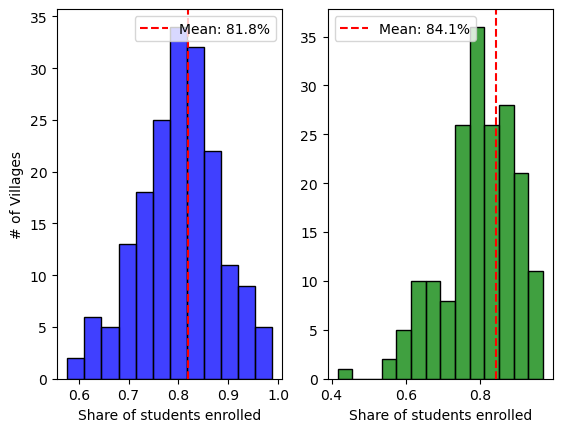

In [64]:
# Your code here

# - calculate avg rate of enrollment of poor hhs in treated villages in 1997
# - then again for 1998

df_enrollment_by_year = (
    df[df['progresa'] == 0]
    [['year','village', 'sc']]
    .value_counts()
    .unstack()
    .rename(columns = {0: 'not_enrolled', 1: 'enrolled'})
    .assign(enrolled_share = lambda dat: dat['enrolled']/(dat['enrolled'] + dat['not_enrolled']))
)

# plots
fig, ax = plt.subplots(1,2)

mean_enroll_97 = np.nanmean(df.query('progresa == 1 & year == 97')['sc'])
mean_enroll_98 = np.nanmean(df.query('progresa == 1 & year == 98')['sc']) 

sns.histplot(df_enrollment_by_year.loc[97,:]['enrolled_share'], color='blue', ax=ax[0])
sns.histplot(df_enrollment_by_year.loc[98,:]['enrolled_share'], color='green', ax=ax[1])

ax[0].axvline(x = mean_enroll_97, color='red', linestyle='--', label=f'Mean: {mean_enroll_97*100:.1f}%')
ax[1].axvline(x = mean_enroll_98, color='red', linestyle='--', label=f'Mean: {mean_enroll_98*100:.1f}%')


#plt.title('')
ax[0].set_ylabel('# of Villages')
ax[1].set_ylabel(None)
ax[0].set_xlabel('Share of students enrolled')
ax[1].set_xlabel('Share of students enrolled')

ax[0].legend()
ax[1].legend()
plt.show()

In [53]:
# T-test for significance of difference
treat_sc97 = df.query('progresa == 1 & year == 97')['sc']
treat_sc98 = df.query('progresa == 1 & year == 98')['sc']

manual_t_test = (
    np.nanmean(treat_sc97) - np.nanmean(treat_sc98)/
    np.sqrt(
        (np.nanvar(treat_sc97)/sum(~np.isnan(treat_sc97))) + 
        (np.nanvar(treat_sc98)/sum(~np.isnan(treat_sc98)))
    )
)

from scipy import stats
t_stat, p_value = stats.ttest_ind(treat_sc97, treat_sc98, nan_policy='omit')
print(f"t-stat: {t_stat:.5f}\np-value: {p_value:.5f}")

t-stat: -6.19762
p-value: 0.00000


*Discuss your results here*

Yes, there looks to be a difference of about `2.7%` between the two samples and that difference appears to be significant at almost any reasonable $\alpha$ level. Interestingly though, there appears to be a larger spread in the 1998 data than in the 1997 data - with more villages on the lower end of the spectrum than before. However, this does not show up when only comparing the means of the two samples.

### 1.5 Graphical exploration, part 2

Repeat the above exercise for poor households in **control villages**, before and after treatment. Do you observe a difference in enrollment in control villages between 1997 and 1998? How does what you observe here affect how you might approach measuring the impact of PROGRESA?

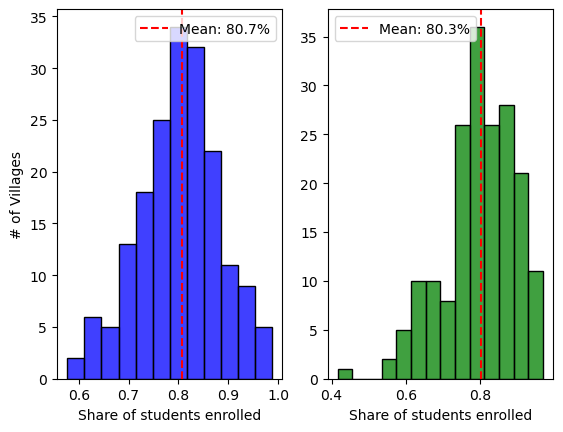

In [65]:
# Your code here

# Control Class

df_enrollment_by_year = (
    df[df['progresa'] == 0]
    [['year','village', 'sc']]
    .value_counts()
    .unstack()
    .rename(columns = {0: 'not_enrolled', 1: 'enrolled'})
    .assign(enrolled_share = lambda dat: dat['enrolled']/(dat['enrolled'] + dat['not_enrolled']))
)

# plots
fig, ax = plt.subplots(1,2)

mean_enroll_97 = np.nanmean(df.query('progresa == 0 & year == 97')['sc'])
mean_enroll_98 = np.nanmean(df.query('progresa == 0 & year == 98')['sc'])

sns.histplot(df_enrollment_by_year.loc[97,:]['enrolled_share'], color='blue', ax=ax[0])
sns.histplot(df_enrollment_by_year.loc[98,:]['enrolled_share'], color='green', ax=ax[1])

ax[0].axvline(x = mean_enroll_97, color='red', linestyle='--', label=f'Mean: {mean_enroll_97*100:.1f}%')
ax[1].axvline(x = mean_enroll_98, color='red', linestyle='--', label=f'Mean: {mean_enroll_98*100:.1f}%')


#plt.title('')
ax[0].set_ylabel('# of Villages')
ax[1].set_ylabel(None)
ax[0].set_xlabel('Share of students enrolled')
ax[1].set_xlabel('Share of students enrolled')

ax[0].legend()
ax[1].legend()
plt.show()

In [67]:
# Test significance
t_stat, p_value = stats.ttest_ind(df.query('progresa == 0 & year == 97')['sc'], df.query('progresa == 0 & year == 98')['sc'], nan_policy='omit')
print(f"t-stat: {t_stat:.5f}\np-value: {p_value:.5f}")

t-stat: 0.74802
p-value: 0.45446


*Discuss your results here*

Whereas before there was a large difference in the two means, that doesn't appear to be the case here at all. In fact, the average enrollment actually went down. This difference does not appear to be significant at any reasonable $\alpha$ level. Therefore we can reasonably assume it is just due to random chance.

As for what this means for how we approach measuring the treatment effect overall, we should still most likely use a difference-of-differences approach, paritcularly because of the differences between the samples noted above. However, we can see a lot of the difference just in the top-line results


## Part 2: Measuring Impact

Our goal is to estimate the causal impact of the PROGRESA program on the social and economic outcomes of individuals in Mexico. We will focus on the impact of the program on school enrollment rates among the poor (those with poor=='pobre'), since only the poor were eligible to receive PROGRESA assistance, and since a primary objective of the program was to increase school enrollment.

### 2.1 Simple differences: T-test

Begin by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment), calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages. Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [121]:
# Your code here
df_enroll98_by_tc = (
    df
    .query('poor == 1')
    .query('year == 98')
    [['progresa', 'sc']]
    .value_counts()
    .unstack() # pivot
    .rename(columns = {0: 'not_enrolled', 1: 'enrolled'})
    .assign(
        enrolled_share = lambda dat: dat['enrolled']/(dat['enrolled'] + dat['not_enrolled'])
    )  
)

display(df_enroll98_by_tc[['enrolled_share']])

df_poor98 = df.query('poor == 1 & year == 98')[['progresa', 'sc']]
t_stat, p_val = stats.ttest_ind(df_poor98[df_poor98['progresa'] == 1]['sc'], df_poor98[df_poor98['progresa'] == 0]['sc'], nan_policy='omit')
print(f"t-stat: {t_stat:.5f}\np-value: {p_val:.5f}")

sc,enrolled_share
progresa,
0,0.807637
1,0.846479


t-stat: 8.35872
p-value: 0.00000
t-stat: 1.66874
p-value: 0.09518


*Discuss your results here*
The difference appears to be significant at any reasonable significance level (< .000005). This alone cannot tell us the effect of the treatment, but it does suggest there was either a big effect of the treatment, a big difference between the two groups receiving treatment or something else unexpected happened.


### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. For now, do not include any other variables in your regression. Discuss the following:

* Based on this model, how much did Progresa increase or decrease the likelihood of a child enrolling? Make sure you express you answer in a sentence that a person with no technical background could understand, using appropriate units.
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [ ]:
# Your code here
from sklearn.linear_model import LinearRegression
import numpy as numpy
import matplotlib.pyplot as plt


X = 

model = LinearRegression().fit

*Discuss your results here*

### 2.3 Multiple Regression

Estimate the above regression, but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, welfare index, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?
* Interpet the coefficient associated with the `dist_sec` variable. Is this evidence that the household's distance from a secondary school has a *causal* impact on educational attainment?

In [ ]:
# Your code here

*Discuss your results here*

### 2.4 Multiple Regression Revisited

For the same set of control variables that you used in 2.3, carry out the following alternative estimation procedure. 

* First, regress the 1998 enrollment of the poor on the control variables, **without including the treatment assignment.** 
* Second, use this model to obtain predicted values of the 1998 enrollment for each child in the sample used to estimate the model in step 1. 
* Third, compute a new value for each child, which is the difference between the actual 1998 enrollment and the predicted enrollment value from step 2. 
* Finally, regress the difference from step 3 on treatment assignment.

Compare the point estimate and the standard error on treatment assignment that you obtained in step 4 to their analogues in 2.3. Explain the results.

In [ ]:
# Your code here

*Discuss your results here*

### 2.5 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in control villages. 

Display your results in a 2x2 table where the rows are Control/Treatment and the columns are 1997/1998. 

* What is your difference-in-difference estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [ ]:
# Your code here

*Discuss your results here*

### 2.6 Difference-in-Difference, version 2 (regression)

Now use a regression specification to estimate the average treatment effects of the program in a difference-in-differences, for the poor households. Do this (i) first without including any control variables; and then (ii) do it a second time including at least 5 control variables. 

* What is your estimate (i) of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* Does your estimate of the impact of Progresa from (i) change when you add control variables as in (ii)? How do you explain these changes, or the lack of changes on the `progresa` coefficient between (i) and (ii)?
* How do the estimates from (i) and (ii) compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences, if any exist?
* What is the counterfactual assumption underlying regression (ii)? 

In [ ]:
# Your code here

*Discuss your results here*

### 2.7 Spillover effects

Thus far, we have focused on the impact of PROGRESA on the school enrollment of poor households. Repeat your analysis in 2.5, instead focusing on (a) the impact of PROGRESA on the school enrollment of non-poor households, and (b) the impact ofo PROGRESA on *other outcomes* of poor households that might plausibly have been affected by the PROGRESA program.
* Do you observe any impacts of PROGRESA on the school enrollment of the non-poor?
* Regardless of whether you find evidence of spillovers to non-poor, describe one or two reasons why PROGRESA *might* have impacted non-poor households. Give concrete examples based on the context in which PROGRESA was implemented.
* Do you observe any impacts of PROGRESA on other aspects of the welfare of poor households? 

In [ ]:
# Your code here

*Discuss your results here*

### 2.8 Summary

* Based on all the analysis you have undertaken to date, do you believe that Progresa had a causal impact on the enrollment rates of poor households in Mexico? 

*Discuss your results here*